In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Description 

We consider a variation on SGD that makes use of the second moment of the 
gradients as follows.

The training loop has three levels :

- over mini-batches
  - we accumulate the gradients computed here and their squares without updating the parameters
- over large batches
  - after each large batch we do the parameters update with the modified SGD
- over epochs

Within mini-batches it is difficult to get the second moment of the gradients,
this would require massive intervention on the nevralgic part of the automatic
differentiation (AD) libraries. 

The large batches are composed of a reasonably large number of minibatches. Let us denote
with $\text{n}$ the number of minibatches that fit in a large batch (say n $\approx 100$).

For each mini-batch ($\text{mb}\approx 10$ images) in a large batch ($\text{lb} \approx 1000$ images) we will compute the gradient with respect to all the trainable parameters :

$$
\nabla^{1}, \dots, \nabla^{\text{n}}
$$

We accumulates these gradients and their squares (elementwise) within a large batch : 

$$
\bar{A} = \frac{1}{n}  \sum_{i=1}^{n} \nabla^{i}
$$

$$
\bar{A^{2}} = \frac{1}{n}  \sum_{i=1}^{n}  \left( \nabla^{i} \right)^2
$$


We then compute the variance of the gradient as $\sigma^2 = \bar{A^{2}} - \left( \bar{A} \right)^2$ and define the

error as 

$$
\varepsilon = \sqrt{ \frac{\sigma^2}{n} } = \frac{\sigma}{\sqrt{n}}
$$

The signal to noise ratio of the gradient is then

$$
\eta = \frac{\bar{A}}{\varepsilon}
$$

From the information in $\eta$ we modify SGD as follows.

At the end of the computation on a large batch we update the parameters with the 
rule 

$$
w  =  w - \lambda \; f \left(  \eta \right ) \bar{A}
$$
where $\lambda$ is the learning rate, $\bar{A}$ is the average gradient computed on 
$\text{n}$ mini-batches within the large batch, and $f$ is :


\begin{equation}
\text{f} =  
\begin{cases} 
1 \;\;\;\;\; \text{if} \;  \eta \geq 1
\\
\eta \;\;\;\;\; \text{if} \; \eta < 1
\end{cases}
\end{equation}

so that when the gradient signal is reliable it is left unchanged while in the opposite case the gradient signal is suppressed by the prefactor $\eta \in [0,1)$.

It is important than to monitor during the training what is the fraction of parameters
for which the modification to the SGD applies, i.e. the fraction of weights such that $\eta < 1$.

We do that for each layer because we noticed that the signal to noise ratio can vary accross layers.

# Dataset and Settings

In [2]:
MODIFIED_SGD = False
SAVE = True

In [3]:
DATASET = 'mnist'
if DATASET     == 'mnist':
    mb_size    = 10         # mini-batch size (default : 10)
    n          = 100        # number of mini-batches in a large batch
    lb_size    = n*mb_size  # large batch size (after this gradient update with modified SGD rule)  
    n_lb       = int(60000.0/(lb_size)) # number of large batches in a epoch
    epochs     = 100
    lr         = 0.01
    momentum   = 0.0    
    mean_imgs  = 0.1307
    std_imgs   = 0.3081
    imgs_shape = (1,28,28)

In [4]:
import os
ROOT = '/home/ansuini/repos/WellTemperedSGD/'
os.chdir(ROOT)

if MODIFIED_SGD:
    RES = os.path.join(ROOT,'results', DATASET, 'modified', str(mb_size) + '_' + str(n)  )
    if not os.path.exists(RES):
        print('Creating directory ' + RES)
        os.mkdir(RES)
        
    FIG = os.path.join(ROOT,'figures', DATASET, 'modified', str(mb_size) + '_' + str(n)  )
    if not os.path.exists(FIG):
        print('Creating directory ' + FIG)
        os.mkdir(FIG)
else:
    RES = os.path.join(ROOT,'results', DATASET,'original', str(mb_size) + '_' + str(n)  )  
    if not os.path.exists(RES):
        print('Creating directory ' + RES)
        os.mkdir(RES)
        
    FIG = os.path.join(ROOT,'figures', DATASET,'original', str(mb_size) + '_' + str(n)  )
    if not os.path.exists(FIG):
        print('Creating directory ' + FIG)
        os.mkdir(FIG)

Creating directory /home/ansuini/repos/WellTemperedSGD/results/mnist/original/10_100
Creating directory /home/ansuini/repos/WellTemperedSGD/figures/mnist/original/10_100


In [5]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchvision
from torchsummary import summary
from tqdm import tqdm
import pandas as pd

from mnist_archs import LeNet
from wtsgd import *

import pickle
from time import time
import numpy as np
np.seed = 1101
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
kwargs = {'num_workers': 2, 'pin_memory': True} if device.type == 'cuda' else {}
print('Device : {}'.format( device ) )

Device : cuda:0


In [7]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(ROOT +  '/data/' + DATASET, train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mean_imgs,), (std_imgs,))                                           
                   ])),
    batch_size=mb_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    
    datasets.MNIST(ROOT + '/data/' + DATASET, train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mean_imgs,), (std_imgs,))                       
                   ])),
    batch_size=mb_size, shuffle=True, **kwargs)

In [8]:
def imshow(img):
    npimg = img.numpy()    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([10, 1, 28, 28])


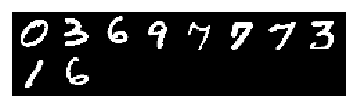

Process Process-2:
Process Process-1:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ansuini/.local/envs/pytorch/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/ansuini/.local/envs/pytorch/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.5/multiprocessing/queues.

In [9]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(images.shape)

### Check labelling

Useful in case of random shuffling of labels

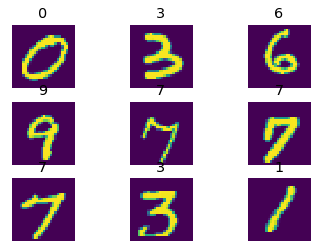

In [10]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i,0,:,:])
    plt.xticks([])
    plt.yticks([])
    plt.title(labels[i].item())

In [11]:
def get_stats(loader):   
    '''
    Compute training statistics (loss and accuracy) on loader data
    '''
    loss = 0.0
    correct = 0
    total = 0       
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        l = loss.to('cpu').item()/total
        acc = 100 * correct/total
        return [l,acc]

# Initialize network, optimizer and loss

In [12]:
model = LeNet()
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
criterion = F.nll_loss

In [13]:
print(model)
print( summary(model, imgs_shape) )

LeNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
            Conv2d-2             [-1, 20, 8, 8]            5020
            Linear-3                   [-1, 50]           16050
            Linear-4                   [-1, 10]             510
Total params: tensor(21840)
Trainable params: tensor(21840)
Non-trainable params: tensor(0)
----------------------------------------------------------------
None


In [14]:
train_stats = []
test_stats  = []
fractions   = []
grad_stats  = []
grad2_stats = []
snr_stats   = []

for epoch in tqdm(range(epochs)):
    
    # init accumulators grad and grad2
    grad  = init_grad(model)
    grad2 = init_grad(model)  
    
    for i, data in enumerate(train_loader, 0):
                       
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)  
       
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward
        outputs = model(inputs)
        loss = criterion(outputs, labels)        
        # compute the grad
        loss.backward()
                
        # accumulate grad and grad2
        grad  = acc_grad(grad,model)
        grad2 = acc_grad2(grad2,model)
        
        if (i + 1) % n == 0 : 
            
            # compute the snr 
            snr = compute_snr(grad, grad2, n, mb_size)
            
            # temper the grad with the information on grad2
            fr = []
            with torch.no_grad():
                for p, g, s in zip(model.parameters(), grad, snr): 
                    
                    
                    # this is the only line where the true gradient is touched
                    if MODIFIED_SGD:
                        p.grad = torch.where(s > 1, g/n, s * g/n)          
                    else:
                        p.grad = g/n
                        
                    fr.append(  ( s < 1).sum().item() / 
                             torch.prod(torch.tensor( s.size() ) ).item()  )       
            fractions.append(fr)
    
            # store statistics about grad, grad2 and snr    
            grad_stats.append(  [ [x.mean().item(), x.std().item()]  for x in grad] )
            grad2_stats.append( [ [x.mean().item(), x.std().item()]  for x in grad2] )
            snr_stats.append(   [ [x.mean().item(), x.std().item()]  for x in snr] )
        
            # this is called after the large batch of n mini-batches
            optimizer.step()
            
            # set to zero accumulators for grad and grad2
            grad  = init_grad(model)
            grad2 = init_grad(model)
            
                          
    # save model
    if SAVE:
        #model.save_state_dict(model, os.path.join( RES, 'model_' + str(epoch) + '.pt') )
        torch.save(model, os.path.join( RES, 'model_' + str(epoch) + '.pt') )
        
    # get statistics
    train_stats.append(get_stats(train_loader))
    test_stats.append(get_stats(test_loader))
        
    # print statistics
    print('Train loss : %g --- Train acc : %g %%' % ( train_stats[-1][0], train_stats[-1][1] )) 
    print('Test  loss : %g --- Test  acc : %g %%' % ( test_stats[-1][0],  test_stats[-1][1] ))         

  1%|          | 1/100 [00:12<21:07, 12.80s/it]

Train loss : 0.221607 --- Train acc : 29.1833 %
Test  loss : 0.221607 --- Test  acc : 29.64 %


  2%|▏         | 2/100 [00:25<20:56, 12.82s/it]

Train loss : 0.1876 --- Train acc : 42.5233 %
Test  loss : 0.187477 --- Test  acc : 42.24 %


  3%|▎         | 3/100 [00:38<20:42, 12.80s/it]

Train loss : 0.106879 --- Train acc : 74.95 %
Test  loss : 0.105368 --- Test  acc : 75.82 %


  4%|▍         | 4/100 [00:51<20:26, 12.78s/it]

Train loss : 0.0627602 --- Train acc : 82.6883 %
Test  loss : 0.0605246 --- Test  acc : 83.6 %


  5%|▌         | 5/100 [01:04<20:18, 12.83s/it]

Train loss : 0.0486195 --- Train acc : 85.5867 %
Test  loss : 0.0462041 --- Test  acc : 86.75 %


  6%|▌         | 6/100 [01:16<20:04, 12.81s/it]

Train loss : 0.0409148 --- Train acc : 88.175 %
Test  loss : 0.038701 --- Test  acc : 88.91 %


  7%|▋         | 7/100 [01:29<19:54, 12.85s/it]

Train loss : 0.0373726 --- Train acc : 88.5667 %
Test  loss : 0.0350019 --- Test  acc : 89.61 %


  8%|▊         | 8/100 [01:42<19:39, 12.83s/it]

Train loss : 0.0351395 --- Train acc : 89.135 %
Test  loss : 0.032801 --- Test  acc : 90.14 %


  9%|▉         | 9/100 [01:55<19:29, 12.85s/it]

Train loss : 0.0305798 --- Train acc : 91.0083 %
Test  loss : 0.0284441 --- Test  acc : 91.69 %


 10%|█         | 10/100 [02:08<19:16, 12.85s/it]

Train loss : 0.0301541 --- Train acc : 90.78 %
Test  loss : 0.0283097 --- Test  acc : 91.54 %


 11%|█         | 11/100 [02:21<19:05, 12.87s/it]

Train loss : 0.0264189 --- Train acc : 92.1967 %
Test  loss : 0.0245541 --- Test  acc : 92.72 %


 12%|█▏        | 12/100 [02:34<18:51, 12.85s/it]

Train loss : 0.0250346 --- Train acc : 92.5467 %
Test  loss : 0.0232422 --- Test  acc : 93.15 %


 13%|█▎        | 13/100 [02:47<18:39, 12.87s/it]

Train loss : 0.0234596 --- Train acc : 93.1367 %
Test  loss : 0.0218548 --- Test  acc : 93.66 %


 14%|█▍        | 14/100 [03:00<18:26, 12.87s/it]

Train loss : 0.02227 --- Train acc : 93.5217 %
Test  loss : 0.020619 --- Test  acc : 93.94 %


 15%|█▌        | 15/100 [03:13<18:16, 12.89s/it]

Train loss : 0.0212064 --- Train acc : 93.8033 %
Test  loss : 0.0195711 --- Test  acc : 94.23 %


 16%|█▌        | 16/100 [03:26<18:03, 12.90s/it]

Train loss : 0.0209736 --- Train acc : 93.7483 %
Test  loss : 0.019304 --- Test  acc : 94.2 %


 17%|█▋        | 17/100 [03:39<17:52, 12.92s/it]

Train loss : 0.0194561 --- Train acc : 94.3783 %
Test  loss : 0.0179911 --- Test  acc : 94.89 %


 18%|█▊        | 18/100 [03:53<17:41, 12.94s/it]

Train loss : 0.0187408 --- Train acc : 94.535 %
Test  loss : 0.0173087 --- Test  acc : 94.84 %


 19%|█▉        | 19/100 [04:06<17:31, 12.98s/it]

Train loss : 0.017741 --- Train acc : 94.8583 %
Test  loss : 0.0162352 --- Test  acc : 95.16 %


 20%|██        | 20/100 [04:19<17:18, 12.98s/it]

Train loss : 0.0172411 --- Train acc : 95.0467 %
Test  loss : 0.0157871 --- Test  acc : 95.4 %


 21%|██        | 21/100 [04:32<17:05, 12.98s/it]

Train loss : 0.016468 --- Train acc : 95.2283 %
Test  loss : 0.0150191 --- Test  acc : 95.55 %


 22%|██▏       | 22/100 [04:46<16:54, 13.00s/it]

Train loss : 0.0162387 --- Train acc : 95.2483 %
Test  loss : 0.0146706 --- Test  acc : 95.75 %


 23%|██▎       | 23/100 [04:59<16:42, 13.02s/it]

Train loss : 0.0155217 --- Train acc : 95.4633 %
Test  loss : 0.0140644 --- Test  acc : 95.86 %


 24%|██▍       | 24/100 [05:12<16:28, 13.01s/it]

Train loss : 0.0150396 --- Train acc : 95.675 %
Test  loss : 0.0135002 --- Test  acc : 95.94 %


 25%|██▌       | 25/100 [05:26<16:18, 13.05s/it]

Train loss : 0.0145273 --- Train acc : 95.765 %
Test  loss : 0.0131186 --- Test  acc : 96.18 %


 26%|██▌       | 26/100 [05:39<16:06, 13.06s/it]

Train loss : 0.0141729 --- Train acc : 95.9033 %
Test  loss : 0.0125423 --- Test  acc : 96.32 %


 27%|██▋       | 27/100 [05:52<15:54, 13.07s/it]

Train loss : 0.0137788 --- Train acc : 95.9783 %
Test  loss : 0.0122607 --- Test  acc : 96.39 %


 28%|██▊       | 28/100 [06:06<15:42, 13.09s/it]

Train loss : 0.0134182 --- Train acc : 96.1567 %
Test  loss : 0.0119084 --- Test  acc : 96.5 %


 29%|██▉       | 29/100 [06:19<15:29, 13.09s/it]

Train loss : 0.0131674 --- Train acc : 96.1433 %
Test  loss : 0.0118311 --- Test  acc : 96.68 %


 30%|███       | 30/100 [06:33<15:17, 13.10s/it]

Train loss : 0.0127747 --- Train acc : 96.265 %
Test  loss : 0.0113918 --- Test  acc : 96.49 %


 31%|███       | 31/100 [06:46<15:05, 13.13s/it]

Train loss : 0.0124686 --- Train acc : 96.295 %
Test  loss : 0.0110087 --- Test  acc : 96.75 %


 32%|███▏      | 32/100 [07:00<14:53, 13.15s/it]

Train loss : 0.0120255 --- Train acc : 96.5317 %
Test  loss : 0.0106662 --- Test  acc : 96.93 %


 33%|███▎      | 33/100 [07:14<14:41, 13.16s/it]

Train loss : 0.0119135 --- Train acc : 96.545 %
Test  loss : 0.0104478 --- Test  acc : 96.96 %


 34%|███▍      | 34/100 [07:27<14:29, 13.18s/it]

Train loss : 0.0116731 --- Train acc : 96.645 %
Test  loss : 0.0103871 --- Test  acc : 96.97 %


 35%|███▌      | 35/100 [07:41<14:17, 13.19s/it]

Train loss : 0.0114453 --- Train acc : 96.6383 %
Test  loss : 0.010188 --- Test  acc : 97.09 %


 36%|███▌      | 36/100 [07:54<14:03, 13.18s/it]

Train loss : 0.0110573 --- Train acc : 96.8117 %
Test  loss : 0.00991438 --- Test  acc : 97.16 %


 37%|███▋      | 37/100 [08:07<13:50, 13.19s/it]

Train loss : 0.0109902 --- Train acc : 96.79 %
Test  loss : 0.00972714 --- Test  acc : 97.14 %


 38%|███▊      | 38/100 [08:22<13:39, 13.22s/it]

Train loss : 0.0108482 --- Train acc : 96.7983 %
Test  loss : 0.00941996 --- Test  acc : 97.16 %


Process Process-233:
Process Process-234:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ansuini/.local/envs/pytorch/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/ansuini/.local/envs/pytorch/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/ansuini/.local/envs/pytorch/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 57, in <li

RuntimeError: DataLoader worker (pid 10157) exited unexpectedly with exit code 1.

In [ ]:
# save loss and accuracies in a dictionary
train_stats = np.asarray(train_stats)
test_stats  = np.asarray(test_stats)
fractions   = np.asarray(fractions)
grad_stats  = np.asarray(grad_stats)
grad2_stats = np.asarray(grad2_stats)
snr_stats   = np.asarray(snr_stats)

tags = ['train_stats', 'test_stats', 'fractions' ]
vals = [train_stats, test_stats, fractions]
training_data = dict(zip(tags, vals))
if SAVE:
    file = open( os.path.join( RES, 'training_data.pt') , 'wb' ) 
    pickle.dump(training_data,file)

In [ ]:
win = 30
layer_names = [m[0] for idx,m in enumerate(model.named_modules()) ][1:]

fig = plt.figure(figsize=(20,20))

plt.subplot(3,3,1)
plt.plot(train_stats[:,0],'-o',label='training loss')
plt.plot(test_stats[:,0],'-o',label='test loss')
plt.xlabel('epoch')
plt.title('loss')


plt.subplot(3,3,2)
plt.plot(train_stats[:,1],'-o',label='training accuracy')
plt.plot(test_stats[:,1],'-o',label='test accuracy')
plt.xlabel('epoch')
plt.title('accuracy')


plt.subplot(3,3,3)
for i in range(len(layer_names)):
    plt.plot(np.arange(n_lb*epochs), pd.rolling_mean(fractions[:,i*2], win*2 ),label=layer_names[i])

plt.legend()
plt.xlabel('epoch')
plt.title('fractions')


plt.subplot(3,3,4)
for i in range(len(layer_names)):
    plt.plot(pd.rolling_mean( grad_stats[:,i*2,0], win ),label=layer_names[i])
plt.legend()
plt.xlabel('epoch')
plt.title('grad mean')

plt.subplot(3,3,5)
for i in range(len(layer_names)):
    plt.plot(pd.rolling_mean( grad_stats[:,i*2,1], win ),label=layer_names[i])
plt.legend()
plt.xlabel('epoch')
plt.title('grad std')

plt.subplot(3,3,6)
for i in range(len(layer_names)):
    plt.plot(pd.rolling_mean( grad2_stats[:,i*2,0], win),label=layer_names[i])
plt.legend()
plt.xlabel('epoch')
plt.title('grad2 mean')

plt.subplot(3,3,7)
for i in range(len(layer_names)):
    plt.plot(pd.rolling_mean( grad2_stats[:,i*2,1], win),label=layer_names[i])
plt.legend()
plt.xlabel('epoch')
plt.title('grad2 std')


plt.subplot(3,3,8)
for i in range(len(layer_names)):
    plt.plot(pd.rolling_mean( snr_stats[:,i*2,0], win),label=layer_names[i])
plt.legend()
plt.xlabel('epoch')
plt.title('snr mean')

plt.subplot(3,3,9)
for i in range(len(layer_names)):
    plt.plot(pd.rolling_mean( snr_stats[:,i*2,1], win),label=layer_names[i])
plt.legend()
plt.xlabel('epoch')
plt.title('snr std')


plt.savefig(os.path.join(FIG, 'mnist.png'))

    
plt.show()